# Pre-excerse

Welcome to the jupyter notebook! Before the tensorflow tutorial, how about excersing on jupyter notebook?<br>
So this is the **introduction to jupyter notebook!**

First, you can execute shell commands following by `!`,<br>
otherwise your commands become ipython scripts.<br>
You can *execute* them by `Ctrl+Enter` (or click `Run` buttom at the top bar).<br>
`Ctrl+m l` to show line numbers.

In [5]:
!pwd

/Users/kurita/repos/tensorflow-tutorial2018


You are using your default shell.

In [16]:
!echo $SHELL

/usr/local/bin/zsh


You can run more complex commands.

In [9]:
!ls;touch foobar;ls -la foobar

README.md                  train.py
Untitled.ipynb             train_data_a_light.txt
data_load.py               train_data_label_light.txt
foobar                     train_data_q_light.txt
hyperparams.py             tutorial.ipynb
modules.py                 vocab.txt
tensorflow
-rw-r--r--  1 kurita  staff  0 Sep 24 23:03 foobar


You can edit the inside of the command by clicking. Edit the following incomplete command to remove *foobar* file.

In [ ]:
rmfoobar

While the commands are running, the state become \[\*\]

In [190]:
!for iii in `seq 10 0`; do sleep 1; echo $iii; done; echo finished!

10
9
8
7
6
5
4
3
2
1
0
finished!


Actually, you can edit textlines on this notebook by double-clicking.<br>
If you want to insert a *text line*, click `+` bottom and select `Code` to `Markdown`. <br>
After you edit a text line, just `Ctrl+Enter` to replace old lines.

You can also include links and pictures as Markdown format.
![jupyter icon](http://jupyter.org/assets/main-logo.svg)
How about creating [your own jupyter notebook](blank.ipynb)\?

Before processing, check you are using virtualenv python (/XXXXXX/tensorflow-tutorial2018/tensorflow/bin/python).

In [8]:
!which python

/Users/kurita/repos/tensorflow-tutorial2018/tensorflow/bin/python


Finally, do not forget you are in *ipython*.

In [191]:
import random
def dice():
    return random.randint(1,6)
print(dice())

2


Let's play with this *dice* function.

[0 0 0 0 0 0]
[154 177 171 160 169 169]


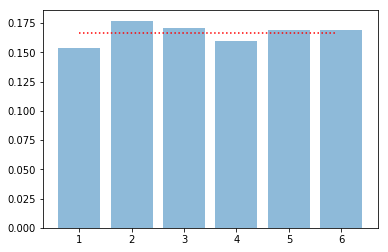

In [192]:
import numpy as np
stat=np.zeros((6,),dtype="int64")  # creating [0,0,0,0,0,0]
print(stat)
N=1000
for i in range(N):
    stat[dice()-1]+=1
print(stat)

# Drawing a graph
!pip install matplotlib
import matplotlib.pyplot as plt
plt.bar(np.arange(1,7),stat/N, alpha=0.5)    # draw a bar graph. alpha for transparency
x = np.arange(1, 6, 0.1)
y = x*0+1./6
plt.plot(x,y, color="red",linestyle="dotted")

Boring graph? Ok, draw a normal distribution.

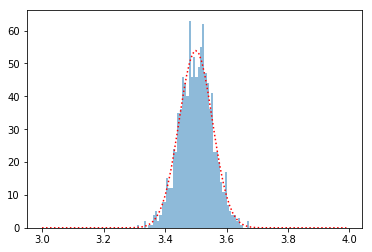

In [197]:
N,M,BINS=1000,1000,50
means=[]
for i in range(N):
    stat=[]
    for j in range(M):
        stat.append(dice())
    means.append(np.mean(stat))

# Drawing a histgram
plt.hist(means, bins=BINS, alpha=0.5) # draw a histgram (distribution) of samples.
# Central limit theorem (中心極限定理)
x = np.arange(3, 4, 0.01)
nu,sigma=3.5,np.sqrt(35/12./M)
y = (1/np.sqrt(2*np.pi*(sigma**2)))*np.exp(-((x-nu)**2/(2*sigma**2))) *((np.max(means)-np.min(means))/BINS*N)
plt.plot(x,y, color="red",linestyle="dotted")

So-called *Matlab-like*!

## Restart ipython

This is a trick to close and re-launch ipython kernel.

In [ ]:
import os; os._exit(00)

# Tensorflow tutorial

Let's enter the tensorflow tutorial.
Run [train.py](http://localhost:8888/edit/train.py).

In [213]:
!python train.py

/Users/kurita/repos/tensorflow-tutorial2018/tensorflow/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
[[ 2  3  5  6 10  0  0  0  0  0  0  0  0  0  0  0]
 [ 1  8  5  9 10  0  0  0  0  0  0  0  0  0  0  0]]
(<tf.Tensor 'shuffle_batch:0' shape=(1, 16) dtype=int32>, <tf.Tensor 'shuffle_batch:1' shape=(1, 16) dtype=int32>, 2)

2018-09-25 19:01:50.148869: I tensorflow/core/platform/cpu_feature_guard.cc:141] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
Graph loaded
*** Epoch 1 ***
Epoch: 1, Mini-batch: 0, loss: 0.693127
Epoch: 1, Mini-batch: 1, loss: 0.868971
Epoch: 1, Mini-batch: 2, loss: 0.733168
Epoch: 1, Mini-batch: 3, loss: 0.780489
*** Epoch 2 ***
Epoch: 2, Mini-batch: 0, loss: 0.820447
Epoch: 2, Mini-batch: 1, loss: 0.700354
Epoch: 2, Mini-batch: 2, loss: 0.763174
Epoch: 2, Mini-batch: 3

Epoch: 43, Mini-batch: 0, loss: 0.787510
Epoch: 43, Mini-batch: 1, loss: 0.708498
Epoch: 43, Mini-batch: 2, loss: 0.630115
Epoch: 43, Mini-batch: 3, loss: 0.771403
*** Epoch 44 ***
Epoch: 44, Mini-batch: 0, loss: 0.685204
Epoch: 44, Mini-batch: 1, loss: 0.781949
Epoch: 44, Mini-batch: 2, loss: 0.696118
Epoch: 44, Mini-batch: 3, loss: 0.742108
*** Epoch 45 ***
Epoch: 45, Mini-batch: 0, loss: 0.738525
Epoch: 45, Mini-batch: 1, loss: 0.734600
Epoch: 45, Mini-batch: 2, loss: 0.650201
Epoch: 45, Mini-batch: 3, loss: 0.671803
*** Epoch 46 ***
Epoch: 46, Mini-batch: 0, loss: 0.685306
Epoch: 46, Mini-batch: 1, loss: 0.727917
Epoch: 46, Mini-batch: 2, loss: 0.673488
Epoch: 46, Mini-batch: 3, loss: 0.603677
*** Epoch 47 ***
Epoch: 47, Mini-batch: 0, loss: 0.721923
Epoch: 47, Mini-batch: 1, loss: 0.767551
Epoch: 47, Mini-batch: 2, loss: 0.646480
Epoch: 47, Mini-batch: 3, loss: 0.703062
*** Epoch 48 ***
Epoch: 48, Mini-batch: 0, loss: 0.689187
Epoch: 48, Mini-batch: 1, loss: 0.726311
Epoch: 48, Mi

Epoch: 88, Mini-batch: 2, loss: 0.665539
Epoch: 88, Mini-batch: 3, loss: 0.644917
*** Epoch 89 ***
Epoch: 89, Mini-batch: 0, loss: 0.618612
Epoch: 89, Mini-batch: 1, loss: 0.664326
Epoch: 89, Mini-batch: 2, loss: 0.566820
Epoch: 89, Mini-batch: 3, loss: 0.643922
*** Epoch 90 ***
Epoch: 90, Mini-batch: 0, loss: 0.655020
Epoch: 90, Mini-batch: 1, loss: 0.702801
Epoch: 90, Mini-batch: 2, loss: 0.653781
Epoch: 90, Mini-batch: 3, loss: 0.615004
*** Epoch 91 ***
Epoch: 91, Mini-batch: 0, loss: 0.613318
Epoch: 91, Mini-batch: 1, loss: 0.652575
Epoch: 91, Mini-batch: 2, loss: 0.611535
Epoch: 91, Mini-batch: 3, loss: 0.634732
*** Epoch 92 ***
Epoch: 92, Mini-batch: 0, loss: 0.656818
Epoch: 92, Mini-batch: 1, loss: 0.655077
Epoch: 92, Mini-batch: 2, loss: 0.624194
Epoch: 92, Mini-batch: 3, loss: 0.712951
*** Epoch 93 ***
Epoch: 93, Mini-batch: 0, loss: 0.658342
Epoch: 93, Mini-batch: 1, loss: 0.687667
Epoch: 93, Mini-batch: 2, loss: 0.587528
Epoch: 93, Mini-batch: 3, loss: 0.615761
*** Epoch 94 

## Code reading
Let's see the simplefied code of Tensorflow.

In [184]:
import tensorflow as tf
import numpy as np

from data_load import get_batch_data, load_vocab
from hyperparams import Hyperparams as hp
from modules import *

This is a command for reset tensorflow graph.<br>
If you change your neural network, run the following code and recreate neural network from the first.

In [185]:
tf.reset_default_graph()

First, define placeholders

In [186]:
idx_q = tf.placeholder(tf.int32, shape=(None, hp.maxlen))
idx_a = tf.placeholder(tf.int32, shape=(None, hp.maxlen))
print(idx_q.shape)
print(idx_a.shape)

(?, 16)
(?, 16)


## Embedding
Change to embeddings

In [187]:
vocab_size, num_units=100,40
# Define
lookup_table = tf.get_variable('lookup_table',
                                       dtype=tf.float32,
                                       shape=[vocab_size, num_units],
                                       initializer=tf.contrib.layers.xavier_initializer())
# Lookup
emb_q = tf.nn.embedding_lookup(lookup_table, idx_q)
emb_a = tf.nn.embedding_lookup(lookup_table, idx_a)
print(emb_q.shape)
print(emb_a.shape)

(?, 16, 40)
(?, 16, 40)


I will explain how to initialize *embedding* later.
Let's define LSTMs.

## LSTM
This is a simple rapper function for stacked bi-LSTM layers.<br>
This works for both CPU and GPU.<br>
https://www.tensorflow.org/api_docs/python/tf/contrib/rnn/stack_bidirectional_rnn

Actually, I don't recommend *simple_stack_bilstm* on GPU.<br>
This is cudnn implementation of stacked LSTM. Unfortunately, **this doesn't work on CPU**.

In [188]:
# input shape must be [mini_batch, time_sequence, embedding]
def cudnn_stack_bilstm(input, num_stacked, dim_hidden, timesteps, dropout_rate, name):
    # Define LSTMs
    bilstmA = tf.contrib.cudnn_rnn.CudnnLSTM(num_stacked, dim_hidden, dropout=dropout_rate, name="forward_lstm")
    bilstmB = tf.contrib.cudnn_rnn.CudnnLSTM(num_stacked, dim_hidden, dropout=dropout_rate, name="backward_lstm")
    # Define Computation Graph
    rnninput = tf.transpose(input, perm=[1,0,2])
    rnnoutputA,_ = bilstmA(rnninput)
    rnnoutputB,_ = bilstmB(rnninput[::-1])
    # 各word毎のhidden representationが欲しい時
    rnnoutput = tf.concat([rnnoutputA,rnnoutputB[::-1]],axis=2)
    rnnoutput = tf.transpose(rnnoutput,perm=[1,0,2])
    # 最初と最後のhidden representationを取ってくる
    # rnnoutput_y = tf.concat([rnnoutputA,rnnoutputB],axis=2)[-1] # shape=[timestep, minibatch, emb]
    return rnnoutput

Alternatively, let's use cudnn compagtible lstm now.

In [117]:
# input shape must be [mini_batch, time_sequence, embedding]
def cudnn_cp_stack_bilstm(input, num_stacked, dim_hidden, timesteps, dropout, name):
    # Unstack to expand input to a list of 'timesteps' tensors of shape (mini_batch, embedding)
    input = tf.unstack(input, timesteps, 1)
    # Define lstm cells with tensorflow
    lstm_fw_cell = [tf.contrib.cudnn_rnn.CudnnCompatibleLSTMCell(dim_hidden, reuse=tf.AUTO_REUSE) for i in range(num_stacked)]
    lstm_bw_cell = [tf.contrib.cudnn_rnn.CudnnCompatibleLSTMCell(dim_hidden, reuse=tf.AUTO_REUSE) for i in range(num_stacked)]
    # Define computation graph of LSTMs
    outputs, _, _ = tf.contrib.rnn.stack_bidirectional_rnn(lstm_fw_cell, lstm_bw_cell, input, dtype=tf.float32)
    # Re-stack at axis of the timesteps.
    outputs=tf.stack(outputs,axis=1)
    return outputs

Let's use *cudnn_cp_stack_bilstm* now.

In [189]:
lstm_units=40
hid_q = cudnn_cp_stack_bilstm(emb_q, 1, lstm_units, hp.maxlen, 0.5, "q")
hid_a = cudnn_cp_stack_bilstm(emb_a, 1, lstm_units, hp.maxlen, 0.5, "a")
print(hid_q.shape)
print(hid_a.shape)

(?, 16, 80)
(?, 16, 80)


The last dimension become twice of LSTM hidden units because of the concatenation of forward and backward LSTMs.
Extract last and forward values of forward and backward LSTMs for a sentence representation.

In [190]:
rep_q = tf.concat([hid_q[:,-1,0:lstm_units+1],hid_q[:,0,lstm_units+1:]], axis=-1)
rep_a = tf.concat([hid_a[:,-1,0:lstm_units+1],hid_a[:,0,lstm_units+1:]], axis=-1)
print(rep_q.shape)
print(rep_a.shape)

(?, 80)
(?, 80)


Concatenate question and answer representation and input to a MLP.

In [191]:
rep = tf.concat([rep_q,rep_q], axis=-1)
hl = tf.layers.dense(rep, hp.hidden_units, activation=tf.nn.relu)
hl = tf.nn.dropout(hl,keep_prob=(0.1))
logits = tf.layers.dense(hl, 2)   # binary classification
prob = tf.nn.softmax(logits)
print(logits.shape)

(?, 2)


Calc loss.

In [192]:
label = tf.placeholder(tf.int32, shape=(None))   # binary class labels
loss = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=label)
mean_loss = tf.reduce_mean(loss)

**Tips:** *sparse_softmax_cross_entropy_with_logits* requires index of labels while *softmax_cross_entropy_with_logits(_v2)* requires distributions of labels.

Define the optimizer.

In [193]:
optimizer = tf.train.AdamOptimizer(learning_rate=hp.lr, beta1=0.9, beta2=0.98, epsilon=1e-8)
train_op = optimizer.minimize(mean_loss)

In [194]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

## Train your net

Train neural network with very simple datasets.

In [197]:
datasets=[
        [np.array([ [1,4,5,8,3]+[0 for _ in range(11)], [1,1,2,6,3]+[0 for _ in range(11)] ]),
         np.array([ [1,2]+[0 for _ in range(14)],       [9,10]+[0 for _ in range(14)]])],
        [np.array([ [1,4,5,5,3]+[0 for _ in range(11)], [1,4,10,5,3]+[0 for _ in range(11)] ]),
         np.array([ [10]+[0 for _ in range(15)],        [10]+[0 for _ in range(15)]])],
        [np.array([ [4,4,5,6,3]+[0 for _ in range(11)], [9,4,2,6,3]+[0 for _ in range(11)] ]),
         np.array([ [1,2]+[0 for _ in range(14)],       [5,10,4,10]+[0 for _ in range(12)]])],
        [np.array([ [4,4,5,8,3]+[0 for _ in range(11)], [1,4,10,5,3]+[0 for _ in range(11)] ]),
         np.array([ [1,2]+[0 for _ in range(14)],        [1,2]+[0 for _ in range(14)]])],
]
labels=[np.array([0,1]), np.array([1,1]), np.array([0,1]), np.array([0,0])]
print(datasets)
print(labels)
print(label)

for epoch in range(1, 101):
    print("*** Epoch %d ***"%epoch)
    for mb,(data,lab) in enumerate(zip(datasets,labels)):
        feed_dict={
                idx_q:data[0],
                idx_a:data[1],
                label:lab,
                }
        log_loss,log_train_op = sess.run([mean_loss,train_op],feed_dict=feed_dict)
        print("Epoch: %d, Mini-batch: %d, loss: %f"%(epoch,mb,log_loss))
print("Done")

[[array([[1, 4, 5, 8, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 1, 2, 6, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]), array([[ 1,  2,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 9, 10,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0]])], [array([[ 1,  4,  5,  5,  3,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 1,  4, 10,  5,  3,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0]]), array([[10,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [10,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0]])], [array([[4, 4, 5, 6, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [9, 4, 2, 6, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]), array([[ 1,  2,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 5, 10,  4, 10,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0]])], [array([[ 4,  4,  5,  8,  3,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 1,  4, 10,  5,  3,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0]]), array([[1, 2, 0, 0, 

Epoch: 45, Mini-batch: 2, loss: 0.693149
Epoch: 45, Mini-batch: 3, loss: 0.666187
*** Epoch 46 ***
Epoch: 46, Mini-batch: 0, loss: 0.650773
Epoch: 46, Mini-batch: 1, loss: 0.691345
Epoch: 46, Mini-batch: 2, loss: 0.693149
Epoch: 46, Mini-batch: 3, loss: 0.667490
*** Epoch 47 ***
Epoch: 47, Mini-batch: 0, loss: 0.672226
Epoch: 47, Mini-batch: 1, loss: 0.686588
Epoch: 47, Mini-batch: 2, loss: 0.749033
Epoch: 47, Mini-batch: 3, loss: 0.700319
*** Epoch 48 ***
Epoch: 48, Mini-batch: 0, loss: 0.649798
Epoch: 48, Mini-batch: 1, loss: 0.789203
Epoch: 48, Mini-batch: 2, loss: 0.693149
Epoch: 48, Mini-batch: 3, loss: 0.564923
*** Epoch 49 ***
Epoch: 49, Mini-batch: 0, loss: 0.714190
Epoch: 49, Mini-batch: 1, loss: 0.693150
Epoch: 49, Mini-batch: 2, loss: 0.522639
Epoch: 49, Mini-batch: 3, loss: 0.694991
*** Epoch 50 ***
Epoch: 50, Mini-batch: 0, loss: 0.703162
Epoch: 50, Mini-batch: 1, loss: 0.682064
Epoch: 50, Mini-batch: 2, loss: 0.684590
Epoch: 50, Mini-batch: 3, loss: 0.695007
*** Epoch 51 

Epoch: 91, Mini-batch: 1, loss: 0.679479
Epoch: 91, Mini-batch: 2, loss: 0.506374
Epoch: 91, Mini-batch: 3, loss: 0.463973
*** Epoch 92 ***
Epoch: 92, Mini-batch: 0, loss: 0.675094
Epoch: 92, Mini-batch: 1, loss: 0.690999
Epoch: 92, Mini-batch: 2, loss: 0.693150
Epoch: 92, Mini-batch: 3, loss: 0.541014
*** Epoch 93 ***
Epoch: 93, Mini-batch: 0, loss: 0.676507
Epoch: 93, Mini-batch: 1, loss: 0.690973
Epoch: 93, Mini-batch: 2, loss: 0.497589
Epoch: 93, Mini-batch: 3, loss: 0.694428
*** Epoch 94 ***
Epoch: 94, Mini-batch: 0, loss: 0.622995
Epoch: 94, Mini-batch: 1, loss: 0.692292
Epoch: 94, Mini-batch: 2, loss: 0.695249
Epoch: 94, Mini-batch: 3, loss: 0.693867
*** Epoch 95 ***
Epoch: 95, Mini-batch: 0, loss: 0.693150
Epoch: 95, Mini-batch: 1, loss: 0.809106
Epoch: 95, Mini-batch: 2, loss: 0.693150
Epoch: 95, Mini-batch: 3, loss: 0.695411
*** Epoch 96 ***
Epoch: 96, Mini-batch: 0, loss: 0.693150
Epoch: 96, Mini-batch: 1, loss: 0.678264
Epoch: 96, Mini-batch: 2, loss: 0.693150
Epoch: 96, Mi

**Tips:** *sess.run(fetches,feed_dict)* is a function to execute real computations and evaluate (get) tensors specified as *fetches*, given the tensors by *feed_dict*. This can be used for training, testing and other computation operations.

## Test with your net

In [198]:
for data,lab in zip(datasets,labels):
    feed_dict={
            idx_q:data[0],
            idx_a:data[1],
            label:lab,
            }
    log_prob = sess.run([prob],feed_dict=feed_dict)
    log_class = np.argmax(log_prob,axis=-1)
    print("Probability: "+str(log_prob))
    print("Argmax: "+str(log_class))

Probability: [array([[0.49883467, 0.50116533],
       [0.49883467, 0.50116533]], dtype=float32)]
Argmax: [[1 1]]
Probability: [array([[0.4894198 , 0.51058024],
       [0.49883467, 0.50116533]], dtype=float32)]
Argmax: [[1 1]]
Probability: [array([[0.7456393 , 0.25436068],
       [0.49883467, 0.50116533]], dtype=float32)]
Argmax: [[0 1]]
Probability: [array([[0.49883467, 0.50116533],
       [0.56734097, 0.4326591 ]], dtype=float32)]
Argmax: [[1 0]]


Actually, this dataset is too tiny to train this network...

## Assign default values to the lookup table.
Use sess.run() after creating a graph.

In [207]:
# Define lookup table.
embedding_shape=(vocab_size, num_units)
emb_w = tf.Variable(tf.constant(0.0, shape=embedding_shape), name="emb_w")
embedding_placeholder_w = tf.placeholder(tf.float32, embedding_shape)
embedding_init_w = emb_w.assign(embedding_placeholder_w)      # `assign` operation.
# ...
sess = tf.Session()
sess.run(tf.global_variables_initializer())
# Run assign computation graph.
init_wmat=np.random.randn(*embedding_shape)                   # Of course, you can swap this with gensim vec. 
sess.run([embedding_init_w], feed_dict={embedding_placeholder_w: init_wmat})

[array([[-0.6176402 ,  1.346004  , -0.45719635, ..., -0.17219022,
         -2.1217787 , -1.8355305 ],
        [ 0.24177887, -0.5585114 ,  0.87253124, ...,  0.3342192 ,
         -1.1395321 ,  2.7439766 ],
        [-0.14339474, -2.2741785 , -0.01487757, ...,  0.170371  ,
         -0.00736693, -0.79158056],
        ...,
        [ 0.43974823,  0.6796133 ,  0.432675  , ...,  0.61743784,
          1.3885504 , -0.8581818 ],
        [ 0.62102765, -0.31394094,  0.73098993, ...,  0.7072901 ,
         -0.15805143, -0.47703704],
        [-1.2269344 ,  1.3161734 ,  2.357299  , ...,  0.9376848 ,
         -1.6746929 , -0.5490803 ]], dtype=float32)]

## Tensorboard

This is a special line for tensorboard. You don't need to run below.

In [257]:
tf.summary.FileWriter(logdir='./graph/', graph=tf.Graph())

In [258]:
!tensorboard --logdir='./graph/'

/Users/kurita/repos/tensorflow-tutorial2018/tensorflow/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
W0925 15:36:04.448749 Reloader tf_logging.py:120] Found more than one graph event per run, or there was a metagraph containing a graph_def, as well as one or more graph events.  Overwriting the graph with the newest event.
W0925 15:36:04.448749 123145489252352 tf_logging.py:120] Found more than one graph event per run, or there was a metagraph containing a graph_def, as well as one or more graph events.  Overwriting the graph with the newest event.
W0925 15:36:04.450213 Reloader tf_logging.py:120] Found more than one metagraph event per run. Overwriting the metagraph with the newest event.
W0925 15:36:04.450213 123145489252352 tf_logging.py:120] Found more than one metagraph event per run. Overwriting the metagraph with the newest eve

Access localhost:PORT_NUM

### Tips
This is the BasicLSTM of Tensorflow. You might see in many websites introducing tensorflow.<br>
However, experts rarely use this.

In [200]:
# input shape must be [mini_batch, time_sequence, embedding]
def simple_stack_bilstm(input, num_stacked, dim_hidden, timesteps, dropout, name):
   # Unstack to expand input to a list of 'timesteps' tensors of shape (mini_batch, embedding)
    input = tf.unstack(input, timesteps, 1)
    # Define lstm cells with tensorflow
    lstm_fw_cell = [tf.contrib.rnn.BasicLSTMCell(dim_hidden, forget_bias=1.0, reuse=tf.AUTO_REUSE, name=name+"_f_"+str(i)) for i in range(num_stacked)]
    lstm_bw_cell = [tf.contrib.rnn.BasicLSTMCell(dim_hidden, forget_bias=1.0, reuse=tf.AUTO_REUSE, name=name+"_b_"+str(i)) for i in range(num_stacked)]
    # Define computation graph of LSTMs
    outputs, _, _ = tf.contrib.rnn.stack_bidirectional_rnn(lstm_fw_cell, lstm_bw_cell, input, dtype=tf.float32)
    outputs=tf.stack(outputs,axis=1)
    return outputs